In [3]:
from scipy import integrate
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import pyplot as plt      
import pandas as pd
from scipy import special                 
import array
import scipy as sp
import scipy.interpolate
import re
import pickle as pickle
def unPackRawFile(raw_path):
    """


    
    - unpacks the .raw file. Not used for the neural network.
    """
    y = np.loadtxt(raw_path, skiprows=6)
    distance = y[:,0]
    pec_vel = y[:,1]
    temp = y[:,2]
    HI_density = y[:,3]
    gas_density = y[:,4]
    gas_metallicity = y[:,5]
   
    return distance, pec_vel, temp, HI_density, gas_density, gas_metallicity

def getPos(path_LOS,linenumber=8):
    """
    the start position of the LOS is given inside each file, (in the comments)
    this function parses the comments to get that information
    """
    f = open(path_LOS)
    x = f.readlines()[linenumber]
    answer = re.search('\(([^)]+)', x).group(1)
    arr = np.array(answer.split(','),dtype=float)
    return arr

def getDir(path_LOS,linenumber=8):
    """
    the direction of the LOS is given inside each file, (in the comments)
    this function parses the comments to get that information
    """
    f = open(path_LOS)
    x = f.readlines()[linenumber]
    answer = re.search('\(([^)]+)', x.split(', ')[1]).group(1)
    arr = np.array(answer.split(','),dtype=float)
    return arr


def convertSphereToCart(theta, phi):
    "converts a unit vector in spherical to cartesian, needed for getGalaxies"
    return np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])

def calculate_gamma(temperature,density,xHI,scale):
    '''Gamma = R(T)*ne/xHI, R(T) = 4.3e-13 * (T/1e4K)^{-0.7), ne = 0.82*nb.
    '''
    omega_b = 0.0479; h = 0.6814
    mean_nb = 1.123e-5/scale**3*omega_b*h**2
    nb = np.multiply(density ,mean_nb); ne = 0.82*nb
    R_T = 4.3e-13 * (np.divide(temperature,1e4))**(-0.7)
    gamma = R_T * ne / xHI
    
def lyman_identification():
    """
    function for identifying lls using neutral fraction as filter
    """
    neutral_fraction_limit = 1e-3
    
    neutral_fraction = []
    real_lyman = []
    gamma = []
    HI = []
    gas_den = []
    real_area_under = []
    which = 0
    for i in range(1000):
        raw_path = 'los.00' + '{0:03}'.format(i) +'.raw'
        distance, pec_vel, temp, HI_density, gas_density, gas_metallicity = unPackRawFile(raw_path)
        #changing the distance from chimp to cmeters
        scale_factor = 0.1453
        distance_cm = distance *scale_factor*3.086e24 /0.68
        position = getPos(raw_path)
        direction = convertSphereToCart(getDir(raw_path)[0],getDir(raw_path)[1])
        for k in range(len(distance) -2):
            if(HI_density[k]/gas_density[k]<neutral_fraction_limit and HI_density[k+1]/gas_density[k+1]>neutral_fraction_limit):
                left_bases = k+1
                peak_fraction = HI_density[k]/gas_density[k]
                peak_HI = HI_density[k]
                peak_distance = distance[k]
                peak_gas = gas_density[k]
                if( k+1 <len(distance)):
                    while(not(HI_density[k]/gas_density[k]>neutral_fraction_limit and HI_density[k+1]/gas_density[k+1]<neutral_fraction_limit) and k <len(distance)-2):
                        right_bases = k +1
                        if(k<len(distance)-1):
                            k+=1
                        if(HI_density[k]/gas_density[k]>peak_fraction):
                            peak_fraction = HI_density[k]/gas_density[k]
                            peak_HI = HI_density[k]
                            peak_distance = distance[k]
                            peak_gas = gas_density[k]
                            peak_gamma = calculate_gamma(temp[k],gas_density[k],peak_fraction,0.1452)
                    area_under = peak_HI *1/2*(distance_cm[right_bases]-distance_cm[left_bases])/0.937415
                    real_distance = [(position[0]/256*40+peak_distance*direction[0])%40, (position[1]/256*40+peak_distance*direction[1])%40,(position[2]/256*40+peak_distance*direction[2])%40]
                    distance_graph = []
                    HI_graph = [ ]
                    distance_real = []
                    for z in range(len(distance)):
                        if(distance[left_bases]<=distance[z]<= distance[right_bases]):
                            distance_graph.append(distance_cm[z])
                            HI_graph.append(HI_density[z])
                            distance_real.append(distance[z])
                    y_int = integrate.cumtrapz(HI_graph,distance_graph,initial = 0)
                    area_under = peak_HI *1/2*(distance_cm[right_bases]-distance_cm[left_bases])/0.937415
                    if(y_int[-1] >= (10**16)and y_int[-1]  <= (10**22)):
                        real_lyman.append([i,y_int[-1],distance[left_bases],distance[right_bases]])
                        real_area_under.append(y_int[-1])
                        neutral_fraction.append(peak_fraction)
                        HI.append(peak_HI)
                        gamma.append(peak_gamma)
                        gas_den.append(peak_gas)
                        which = [i,distance[left_bases], distance[right_bases], peak_distance]
    return real_lyman,neutral_fraction,gamma,HI,gas_den,which,real_area_under

In [10]:
real_lyman,neutral_fraction,gamma,HI,gas_den,which,real_area_under = lyman_identification()

KeyboardInterrupt: 

In [4]:
raw_path = 'los.00' + '{0:03}'.format(8) +'.raw'
distance, pec_vel, temp, HI_density, gas_density, gas_metallicity = unPackRawFile(raw_path)

In [5]:
[8, 3.84486704942416e+16, 10.04463, 10.05498],
[8, 2.511209181393279e+19, 45.29454, 45.32244],
[8, 4.7166490439667704e+16, 45.29454, 45.32244],
[8, 2.5108992872752208e+20, 58.48083, 58.51939],
[8, 2.1825573248229523e+17, 71.55349, 71.57075],
bounds = [
[ 10.04463, 10.056],
[45.29454, 45.32244],
[47.27499, 47.2787],
[58.48083, 58.51939],
[71.55349, 71.571],
]

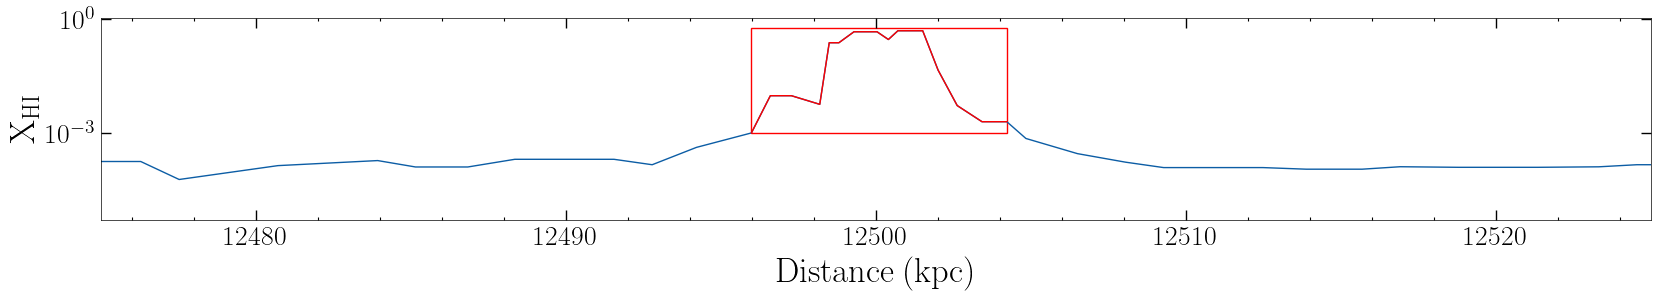

In [13]:
import matplotlib.patches as patches
scale_to_mega_parsec = 0.1453*1000/0.68
with plt.style.context('science','notebook'):
    fig, ax = plt.subplots()
    fig.set_figwidth(20)
    plt.plot(distance*scale_to_mega_parsec,HI_density/gas_density)
    count = 0
    index = []
    index2 = []
    index3 = []
    index4 = []
    for i in range(len(distance)):
        if(bounds[0][0]<=distance[i]<=bounds[0][1]):
            index.append(i)
        if(bounds[1][0]<=distance[i]<=bounds[1][1]):
            index2.append(i)
        if(bounds[2][0]<=distance[i]<=bounds[2][1]):
            index3.append(i)
        if(bounds[3][0]<=distance[i]<=bounds[3][1]):
            index4.append(i)    

    rect = patches.Rectangle((58.48083*scale_to_mega_parsec,1e-3),(58.51939-58.48083)*scale_to_mega_parsec,.6, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.ylabel("$\mathrm{X_{HI}}$",fontsize = 25)
    plt.plot(distance[index2]*scale_to_mega_parsec,HI_density[index2]/gas_density[index2],color = 'red')
    plt.plot(distance[index]*scale_to_mega_parsec,HI_density[index]/gas_density[index],color = 'red')
    plt.plot(distance[index3]*scale_to_mega_parsec,HI_density[index3]/gas_density[index3],color = 'red')
    plt.plot(distance[index4]*scale_to_mega_parsec,HI_density[index4]/gas_density[index4],color = 'red')
    ax.tick_params(axis='both', which='major',length = 7, width = 1,labelsize=20)
    ax.tick_params(axis='both', which='minor', length = 2, width = .8,labelsize=20)

    plt.xlim(12475,12525)
    plt.xlabel("$\mathrm{Distance\: (kpc)}$",fontsize = 25)
    plt.yscale("log")
    plt.savefig("neutral_fraction_cut_off_visualized_short_kpc.pdf")